# **Notebook 1: Data Extraction, Transformation and Loading**

## Objectives

* Import raw data from Kaggle into a dataframe
* Clean data to remove duplicate values and remove outliers
* Identify and handle missing data

## Inputs

* Raw data files from [CO2 Emissions Dataset](https://www.kaggle.com/datasets/shreyanshdangi/co-emissions-across-countries-regions-and-sectors/data)

## Outputs

* Generates clean_data.csv for use in hypothesis testing and visualisations

## Additional Comments

* If you have any additional comments that don't fit in the previous bullets, please state them here. 



---

# Import Packages

Import packages needed to run the notebook

In [1]:
%matplotlib inline
import numpy as np
import pandas as pd
from ydata_profiling import ProfileReport
import matplotlib.pyplot as plt
import seaborn as sns

# Import Data

Import raw data into dataframe, ready for processing

In [2]:
# set path to data file
path = "../raw_data/data.csv"

# assign data to dataframe
df_raw = pd.read_csv(path)

# display dataframe
df_raw.head()

,Description,Name,year,iso_code,population,gdp,cement_co2,cement_co2_per_capita,co2,co2_growth_abs,...,share_global_other_co2,share_of_temperature_change_from_ghg,temperature_change_from_ch4,temperature_change_from_co2,temperature_change_from_ghg,temperature_change_from_n2o,total_ghg,total_ghg_excluding_lucf,trade_co2,trade_co2_share
0,Country,Afghanistan,1850,AFG,3752993.0,NaN,0.0,0.0,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,7.436,0.629,NaN,NaN
1,Country,Afghanistan,1851,AFG,3767956.0,NaN,0.0,0.0,NaN,NaN,...,NaN,0.156,0.0,0.0,0.0,0.0,7.500,0.633,NaN,NaN
2,Country,Afghanistan,1852,AFG,3783940.0,NaN,0.0,0.0,NaN,NaN,...,NaN,0.155,0.0,0.0,0.0,0.0,7.560,0.637,NaN,NaN
3,Country,Afghanistan,1853,AFG,3800954.0,NaN,0.0,0.0,NaN,NaN,...,NaN,0.155,0.0,0.0,0.0,0.0,7.620,0.641,NaN,NaN
4,Country,Afghanistan,1854,AFG,3818038.0,NaN,0.0,0.0,NaN,NaN,...,NaN,0.155,0.0,0.0,0.0,0.0,7.678,0.644,NaN,NaN


# Initital Data Cleaning

First I will do some initital data cleaning steps:
1. Check for duplicate rows and remove if found
2. Limit data to country information to fit the requirements of the analysis
3. Limit data to last 50 years to make analysis easier to manage and findings more relevant to current times

In [3]:
# drop any duplicate rows
df_raw.drop_duplicates(inplace=True)

# select rows where Description is equal to Country
df_raw = df_raw.loc[df_raw['Description'] == "Country"]

# limit data to last 50 years
df_raw = df_raw.loc[df_raw["year"] >= 1975]

df_raw.shape

(9702, 80)

The next step is to drop columns which aren't needed for analysis, this will reduce the size of the data file making processing more efficient and the data easier to work with.<br>
(GPT-5 was used to format column names)

In [11]:
# create a list of columns names to keep in the dataset
req_columns = ["Name", "iso_code", "year", "population", "gdp", "primary_energy_consumption", "co2", "co2_including_luc", "total_ghg", "co2_growth_abs", "co2_growth_prct",
               "co2_per_capita", "co2_per_gdp", "energy_per_capita", "energy_per_gdp", "cement_co2", "coal_co2", "flaring_co2", "gas_co2", "land_use_change_co2", "oil_co2",
               "share_global_co2", "share_global_co2_including_luc", "cumulative_co2", "cumulative_co2_including_luc", "share_global_cumulative_co2"]

# create a new dataframe with only the required columns
df_trimmed = df_raw[req_columns].copy()
df_trimmed.head()

,Name,iso_code,year,population,gdp,primary_energy_consumption,co2,co2_including_luc,total_ghg,co2_growth_abs,...,coal_co2,flaring_co2,gas_co2,land_use_change_co2,oil_co2,share_global_co2,share_global_co2_including_luc,cumulative_co2,cumulative_co2_including_luc,share_global_cumulative_co2
125,Afghanistan,AFG,1975,12773967.0,1.517777e+10,NaN,2.121,5.732,21.901,0.208,...,0.399,0.304,0.475,3.610,0.874,0.012,0.026,21.287,280.878,0.004
126,Afghanistan,AFG,1976,13059861.0,1.602361e+10,NaN,1.981,5.286,21.624,-0.141,...,0.425,0.293,0.300,3.305,0.883,0.011,0.023,23.267,286.164,0.004
127,Afghanistan,AFG,1977,13340758.0,1.520736e+10,NaN,2.384,5.391,21.517,0.403,...,0.451,0.381,0.513,3.007,0.975,0.013,0.022,25.652,291.555,0.005
128,Afghanistan,AFG,1978,13611445.0,1.633783e+10,NaN,2.153,4.786,20.887,-0.231,...,0.576,0.283,0.301,2.632,0.936,0.011,0.020,27.805,296.340,0.005
129,Afghanistan,AFG,1979,13655572.0,1.591379e+10,NaN,2.233,4.990,20.564,0.079,...,0.352,0.267,0.385,2.757,1.165,0.011,0.021,30.038,301.330,0.005


The last step is to select countries with the highest cummulative or co2 per capita levels, so that analysis can focus on the most impactful countries for emissions.<br>
(Method and steps for data filtering suggested by copilot)

In [12]:
# create a temporary dataframe with only the columns of interest for the most recent year
df_temp = df_trimmed.loc[df_trimmed['year'] == 2023, ['Name','cumulative_co2', 'co2']]

# calculate interquartile range, we are interested in the top 75% of values
iqr_cum, iqr_cap = df_temp[['cumulative_co2', 'co2']].quantile(.75)

# select countries where values are higher than IQR3
df_filtered = df_temp[(df_temp['cumulative_co2'] >= iqr_cum) | (df_temp['co2'] >= iqr_cap)]

# remove countries which do not meet the thresholds from the main dataset
df_trimmed = df_trimmed[df_trimmed['Name'].isin(df_filtered['Name'])].copy()
df_trimmed['Name'].value_counts().shape


(58,)

---

# Initial Data Exploration

Next I will use y-data profiling to learn more about the dataset and find out if any further transformation is required to prepare it for use in visualisations.<br>
The preview from the table above shows some columns that will need to be rescaled (e.g. population and gdp) and some missing data to be handled (e.g. primary_energy_consumption and trade_co2_share).

In [13]:
profile = ProfileReport(df=df_trimmed, minimal=True)
profile.to_notebook_iframe()

Summarize dataset:   0%|          | 0/5 [00:00<?, ?it/s]

Generate report structure:   0%|          | 0/1 [00:00<?, ?it/s]

Render HTML:   0%|          | 0/1 [00:00<?, ?it/s]

This has highlighted missing data in several columns which will need to be handled.<br>
Population data would benefit from being rescaled to a more human readable format. <br>
GDP is largly reported in scientific notation format and is not intuitive to interpret for most people, it could be beneficial to rescale this column. It is currently reported in $, but grouping as thousands or millions may make more sense.

---

# Basic Descriptives and Visualisations

This section includes basic data descriptives and visualisations which are used to inform final data transformations.<br>

## Population
Population data would benefit from being scaled to a more human readable format<br>
(GPT-5 was used to refactor the dataframe creation code and https://stackoverflow.com/questions/40347689/dataframe-describe-suppress-scientific-notation was used to reformat the descriptives output)

In [14]:
# create dataframe with population data for 2023
df_temp = df_trimmed.loc[df_trimmed['year'] == 2023, ['Name','population']]
# reset dataframe index
df_temp.reset_index(drop=True)

# create descriptives for population and global co2 share, making sure format doesn't include scientific notation
df_temp.describe().apply(lambda s: s.apply('{0:.2f}'.format))

,population
count,58.00
mean,112292963.12
std,261843136.68
min,2979087.00
25%,13307801.75
50%,39030973.00
75%,89774156.75
max,1438069597.00


These values suggest that rescaling population into millions would be a good way to rescale the data<br>
(Code adapted from https://stackoverflow.com/questions/43675014/dividing-a-dataframe-column-and-then-rounding)

In [15]:
# create a new population column by dividing population values by 1m and round to 2 decimal places
df_trimmed['pop(m)'] = df_trimmed['population'].div(1000000).round(2)
df_trimmed.head()

,Name,iso_code,year,population,gdp,primary_energy_consumption,co2,co2_including_luc,total_ghg,co2_growth_abs,...,flaring_co2,gas_co2,land_use_change_co2,oil_co2,share_global_co2,share_global_co2_including_luc,cumulative_co2,cumulative_co2_including_luc,share_global_cumulative_co2,pop(m)
473,Algeria,DZA,1975,15678601.0,6.488381e+10,70.370,32.001,61.643,91.422,0.125,...,14.991,4.459,29.642,11.291,0.188,0.279,290.132,943.029,0.057,15.68
474,Algeria,DZA,1976,16409170.0,6.915011e+10,82.102,39.131,52.327,95.218,7.130,...,20.758,6.063,13.196,11.035,0.218,0.227,329.264,995.356,0.063,16.41
475,Algeria,DZA,1977,17015987.0,7.543803e+10,90.213,41.845,49.837,98.898,2.714,...,22.893,3.605,7.992,13.868,0.226,0.208,371.108,1045.193,0.068,17.02
476,Algeria,DZA,1978,17506978.0,8.510392e+10,113.361,62.455,66.645,122.399,20.610,...,23.541,23.856,4.189,13.165,0.328,0.272,433.564,1111.837,0.077,17.51
477,Algeria,DZA,1979,18036655.0,9.275390e+10,148.540,45.546,49.101,109.351,-16.910,...,19.284,8.167,3.556,15.359,0.232,0.202,479.109,1160.938,0.082,18.04


Here is a histogram to visualise population counts after rescaling

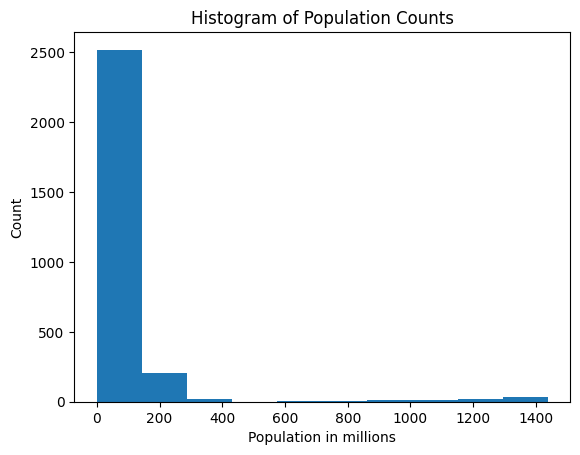

In [16]:
# histogram of population
plt.hist(df_trimmed['pop(m)'])
plt.title("Histogram of Population Counts")
plt.xlabel("Population in millions")
plt.ylabel("Count")
plt.show()

This chart shows that most population data is on the lower end of the scale, even after removing low impact countries from analysis.<br>
There are a few outlier countries with very high populations, but as they are likely to also have higher emission levels these will remain.

## GDP
GDP data would benefit from being rescaled to a more human friendly format.

In [17]:
df_trimmed['gdp'].describe()

count    2.732000e+03
mean     1.068110e+12
std      2.352258e+12
min      4.988309e+09
25%      1.617548e+11
50%      3.587860e+11
75%      1.036242e+12
max      2.696600e+13
Name: gdp, dtype: float64

Before rescaling I will need to handle missing values for GDP.<br>
(Code provided by GPT-5)

In [26]:
# show countries with missing gdp in df_trimmed and how many missing rows per country
missing_counts = df_trimmed[df_trimmed['gdp'].isna()].groupby('Name').size().sort_values(ascending=False)
print(f"Total countries with missing gdp: {missing_counts.shape[0]}")
missing_counts.head()

Total countries with missing gdp: 58


Name
North Korea    16
Slovakia       11
Belarus         6
Ukraine         6
Kazakhstan      6
dtype: int64

All countries have some missing gdp data, but each country has at least some gdp data.<br>
I will use the fill up method to fill in missing values as it is assumed that earlier years are more likely to contain missing values than more recent ones. <br>
This method may skew earlier data as gdp is likely to increase over time.

In [34]:
# upward fill missing GDP values
df_trimmed['gdp'].bfill(inplace=True)
# perform a forward fill to catch any remaining missing values
df_trimmed['gdp'].ffill(inplace=True)
df_trimmed['gdp'].info()


<class 'pandas.core.series.Series'>
Index: 2842 entries, 473 to 33928
Series name: gdp
Non-Null Count  Dtype  
--------------  -----  
2842 non-null   float64
dtypes: float64(1)
memory usage: 44.4 KB


Now that all missing data has been filled we can rescale GDP.<br>
The minimum value is 142,968,000 (142 million) and the highest number is 26,966,000,000,000 (26 trillion).<br>
Rescaling GDP into billion dollars seems like a good method for producing values that can be understood intuitively.<br>
(https://www.calculatorsoup.com/calculators/math/scientific-notation-converter.php was used to convert scientific notation into real numbers)

In [35]:
# create new gdp column by dividing gdp by 1b and rounding to 2 decimal places
df_trimmed['gdp($b)'] = df_trimmed['gdp'].div(1000000000).round(2)
df_trimmed.head()

,Name,iso_code,year,population,gdp,primary_energy_consumption,co2,co2_including_luc,total_ghg,co2_growth_abs,...,gas_co2,land_use_change_co2,oil_co2,share_global_co2,share_global_co2_including_luc,cumulative_co2,cumulative_co2_including_luc,share_global_cumulative_co2,pop(m),gdp($b)
473,Algeria,DZA,1975,15678601.0,6.488381e+10,70.370,32.001,61.643,91.422,0.125,...,4.459,29.642,11.291,0.188,0.279,290.132,943.029,0.057,15.68,64.88
474,Algeria,DZA,1976,16409170.0,6.915011e+10,82.102,39.131,52.327,95.218,7.130,...,6.063,13.196,11.035,0.218,0.227,329.264,995.356,0.063,16.41,69.15
475,Algeria,DZA,1977,17015987.0,7.543803e+10,90.213,41.845,49.837,98.898,2.714,...,3.605,7.992,13.868,0.226,0.208,371.108,1045.193,0.068,17.02,75.44
476,Algeria,DZA,1978,17506978.0,8.510392e+10,113.361,62.455,66.645,122.399,20.610,...,23.856,4.189,13.165,0.328,0.272,433.564,1111.837,0.077,17.51,85.10
477,Algeria,DZA,1979,18036655.0,9.275390e+10,148.540,45.546,49.101,109.351,-16.910,...,8.167,3.556,15.359,0.232,0.202,479.109,1160.938,0.082,18.04,92.75


Here's a histogram to show GDP after rescaling.

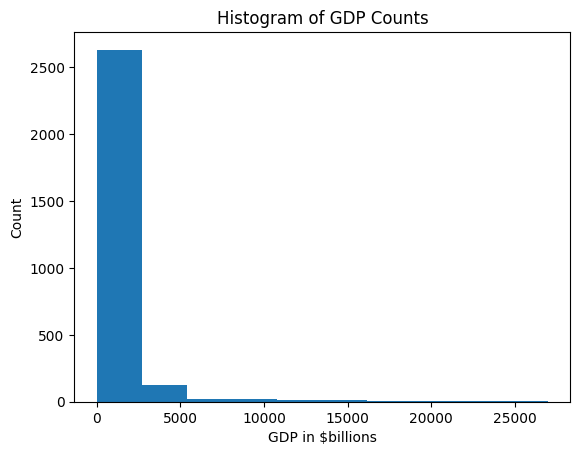

In [36]:
# histogram of population
plt.hist(df_trimmed['gdp($b)'])
plt.title("Histogram of GDP Counts")
plt.xlabel("GDP in $billions")
plt.ylabel("Count")
plt.show()

Similarly to population most values are on the lower end of the scale, with a few higher outliers which we would expect to also contribute more highly to emissions.

## Missing Values
Now I need to identify and handle any remaining missing data.<br>
(Code improved by GPT-5)

In [ ]:
# show columns in df_trimmed that have missing values
missing = df_trimmed.isnull().sum()
missing = missing[missing > 0].sort_values(ascending=False)
missing

flaring_co2                       320
energy_per_gdp                    152
co2_per_gdp                       110
gas_co2                           107
primary_energy_consumption         74
energy_per_capita                  74
co2_including_luc                  49
land_use_change_co2                49
share_global_co2_including_luc     49
cumulative_co2_including_luc       49
coal_co2                           47
dtype: int64

There are several columns with missing data, I want to identify any countries with no data for these metrics as these would not be good targets for back or forward fill methods.<br>
(Code written by GPT-5)

In [ ]:
# show countries with high missing values for a metric
missing_over_40 = []

for col in missing.index:
    counts = df_trimmed[df_trimmed[col].isna()].groupby('Name').size()
    for name, cnt in counts.items():
        if cnt > 40:
            missing_over_40.append((name, col, int(cnt)))

if missing_over_40:
    for name, col, cnt in missing_over_40:
        print(f"{name}: column '{col}' missing {cnt} rows")
else:
    print("No country has more than 40 missing values for any column")

North Korea: column 'gas_co2' missing 49 rows
Taiwan: column 'co2_including_luc' missing 49 rows
Taiwan: column 'land_use_change_co2' missing 49 rows
Taiwan: column 'share_global_co2_including_luc' missing 49 rows
Taiwan: column 'cumulative_co2_including_luc' missing 49 rows


My data owner (a copilot persona) has said that this missing data should not be imputed for accountability metrics, instead this missing data will be flagged in relevant visualisations.<br>
The rest of the missing values will be filled using the back/forward fill method using existing values, this may lead to some skew in time series analysis.<br>
(GPT-5 suggested code to guard against division errors)

In [46]:
# fill missing energy values
df_trimmed['primary_energy_consumption'].bfill(inplace=True)
# perform a forward fill to catch any remaining missing values
df_trimmed['primary_energy_consumption'].ffill(inplace=True)

# gaps in calculated columns can now be filled using the imputed data
calc_col = ['energy_per_gdp', 'co2_per_gdp', 'energy_per_capita']

# calculate and fill missing values
df_trimmed['energy_per_gdp'] = df_trimmed['energy_per_gdp'].fillna(df_trimmed['primary_energy_consumption'] / df_trimmed['gdp'])
df_trimmed['co2_per_gdp'] = df_trimmed['co2_per_gdp'].fillna(df_trimmed['co2'] / df_trimmed['gdp'])
df_trimmed['energy_per_capita'] = df_trimmed['energy_per_capita'].fillna(df_trimmed['primary_energy_consumption'] / df_trimmed['population'])

# guard against division issues
df_trimmed.replace([np.inf, -np.inf], np.nan, inplace=True)

# show columns in df_trimmed that have missing values
missing = df_trimmed.isnull().sum()
missing = missing[missing > 0].sort_values(ascending=False)
missing

flaring_co2                       320
gas_co2                           107
co2_including_luc                  49
land_use_change_co2                49
share_global_co2_including_luc     49
cumulative_co2_including_luc       49
coal_co2                           47
dtype: int64

In [ ]:
# drop unnecessary columns
df_trimmed.drop(['gdp'], axis=1, inplace=True)
df_trimmed.drop(['population'], axis=1, inplace=True)

---

# Output Cleaned Data

Save cleaned data to a scv file ready to be used for visualisations, hypothesis testing, model building and dashboarding.

In [ ]:
# export cleaned data to csv


This is the end of Notebook 1, users should open 02_statistics_and_visualisations.ipynb to continue analysis.